In [1]:
import argparse, os
import utils
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import cucim.skimage.metrics as met


number of common Subjects  171


In [2]:
import torch
import os
import numpy as np
import torch
import random
import math
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from itertools import islice
import h5py
import os
np.seterr(all="ignore")

loaded = {}
loaded_gt ={}
shape_3t = [145,174,174]
shape_7t = [173,207,173]
shape_ratio = [round(shape_7t[i]/shape_3t[i],1) for i in range(3)]
path,tot = "",""


def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    act_ids = []
    print(shape_ratio)
    for i in ids:
        name = path['3T'][i]['h5']
        if(not os.path.isfile(name)):
            continue
        res_vol = h5py.File(name, 'r')
        
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:] }
        
        name = path['7T'][i]['GT']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:] }
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()
        act_ids.append(i)
    return act_ids


def interpolate(data,size):
    if(len(data.shape)==3):
        inp = torch.unsqueeze(data, 0)
    else:
        inp = torch.permute(data, (3,0,1,2))
    inp = torch.unsqueeze(inp, 0)
    interpolated = torch.nn.functional.interpolate(inp,size = torch.Size(size))
    interpolated = torch.permute(interpolated, (2,3,4,1,0))
    
    if(len(data.shape)==3):
        interpolated = torch.squeeze(interpolated)
    return torch.squeeze(interpolated)
    

In [94]:
class hcp_data(torch.utils.data.Dataset):
    def __init__(self, opt,ids):
        super(hcp_data).__init__()
        self.blk_size = opt.block_size
        self.ret_points = opt.ret_points
        self.thres = opt.thres
        self.base_dir = opt.dir if opt.dir != None else "/storage/users/arihant"
        self.ids = ids
        self.debug = opt.debug
        self.scale = opt.scale
        if(opt.sort == True):
            self.ids.sort()
        self.preload_data()


    def __len__(self):
        return self.blk_indx[-1]
    
    def set_scale(self, scale,blk_size):
        self.scale = scale
        self.blk_size = blk_size
        self.preload_data()
        
    def __getitem__(self,indx):

        blk_idx = np.searchsorted(self.blk_indx, indx)
        vol_idx = self.ids[blk_idx]
        blk_idx = indx - self.blk_indx[blk_idx]
        if(self.ret_points):
            return self.loaded_blk[vol_idx][blk_idx,...],self.loaded_fa[vol_idx][blk_idx,...],self.loaded_adc[vol_idx][blk_idx,...],self.loaded_rgb[vol_idx][blk_idx,...],self.loaded_ret_lr[vol_idx][blk_idx,...],self.loaded_ret_hr[vol_idx][blk_idx,...],vol_idx
        else:
            return self.loaded_blk[vol_idx][blk_idx,...],self.loaded_fa[vol_idx][blk_idx,...],self.loaded_adc[vol_idx][blk_idx,...],self.loaded_rgb[vol_idx][blk_idx,...]
        
    def preload_data(self):
        
        self.blk_indx = []
        self.loaded_blk = {}
        self.loaded_adc = {}
        self.loaded_fa = {}
        self.loaded_rgb = {}
        self.loaded_ret_lr = {}
        self.loaded_ret_hr = {}
        for i in self.ids:
            self.loaded_blk[i],self.loaded_adc[i],self.loaded_fa[i],self.loaded_rgb[i],self.loaded_ret_lr[i],self.loaded_ret_hr[i] = self.pre_proc(i)
            if(self.debug == True):
                print(i,"loaded")
        self.blk_indx = np.cumsum(self.blk_indx)

    
    def blk_points_pair(self,datalr,datahr,blk_size = [16,16,4],sca = (1,1,1),stride=(0,0,0),debug=False):
    
        shpind = torch.nonzero(datalr)
        xmin,xmax = torch.min(shpind[:,0]).item(),torch.max(shpind[:,0]).item()
        ymin,ymax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,1]).item()
        zmin,zmax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,2]).item()
        
        # determine starting and ending indices of each block
        
        lr_start = [xmin,ymin,zmin]
        lr_end = [xmax - blk_size[0] + 1,ymax - blk_size[1] + 1,zmax - blk_size[2] + 1]
        
        shpind = torch.nonzero(datahr)
        xmin,xmax = torch.min(shpind[:,0]).item(),torch.max(shpind[:,0]).item()
        ymin,ymax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,1]).item()
        zmin,zmax = torch.min(shpind[:,1]).item(),torch.max(shpind[:,2]).item()
        
        blk_size_hr = [round(blk_size[i]*sca[i]) for i in range(3)]
        hr_start = [xmin,ymin,zmin]
        hr_end = [xmax - blk_size_hr[0] + 1,ymax - blk_size_hr[1] + 1,zmax - blk_size_hr[2] + 1]
#         print(datalr.shape,datahr.shape)

        a,b = [lr_end[i] - lr_start[i] for i in range(3)],[hr_end[i] - hr_start[i] for i in range(3)]
        offset = [round(b[i]/a[i],1) for i in range(3)]
        ranges_lr = [np.arange(lr_start[i], lr_end[i], blk_size[i] - stride[i]) for i in range(3)]
        ranges_hr = [np.round(ranges_lr[i]*offset[i]) for i in range(3)]
        if(debug == True):
            return {'hr':(hr_start,hr_end),'lr':(lr_start,lr_end)}
        
        ind_block_lr = []
        ind_block_hr = []
        count = 0

        for ii in np.arange(0, ranges_lr[0].shape[0]):
            for jj in np.arange(0, ranges_lr[1].shape[0]):
                for kk in np.arange(0, ranges_lr[2].shape[0]):
                    x,y,z = ranges_lr[0][ii],ranges_lr[1][jj],ranges_lr[2][kk]
                    temp_lr = np.array([x, x + blk_size[0]-1, 
                                        y, y + blk_size[1]-1, 
                                        z, z + blk_size[2]-1]).astype(int)
                    
                    x,y,z = ranges_hr[0][ii],ranges_hr[1][jj],ranges_hr[2][kk]
                    temp_hr = np.array([x, x + blk_size_hr[0]-1,
                                        y, y + blk_size_hr[1]-1,
                                        z, z + blk_size_hr[2]-1]).astype(int)
                    
                    
                    curr_blk = datalr[temp_lr[0]:temp_lr[1]+1, temp_lr[2]:temp_lr[3]+1, temp_lr[4]:temp_lr[5]+1, ...]
                    curr_blk_hr = datahr[temp_hr[0]:temp_hr[1]+1, temp_hr[2]:temp_hr[3]+1, temp_hr[4]:temp_hr[5]+1, ...]
#                     print(curr_blk.size(),curr_blk.shape,curr_blk_hr.shape,curr_blk_hr.size())
                    if((torch.numel(curr_blk) != 0 and torch.count_nonzero(curr_blk)/torch.numel(curr_blk) > self.thres) and 
                      (torch.numel(curr_blk_hr) != 0 and torch.count_nonzero(curr_blk_hr)/torch.numel(curr_blk_hr) > self.thres)):
                        ind_block_lr.append(temp_lr)
                        ind_block_hr.append(temp_hr)
                        count = count + 1
                    
        # print(blk_size_hr)
        ind_block_lr = np.stack(ind_block_lr)
        ind_block_lr = ind_block_lr.astype(int)
        ind_block_hr = np.stack(ind_block_hr)
        ind_block_hr = ind_block_hr.astype(int)
        # print(ind_block)
        return ind_block_lr,ind_block_hr,len(ind_block_lr),ranges_lr,ranges_hr


    def extract_block(self,data, inds):
            blocks = []
            for ii in np.arange(inds.shape[0]):
                inds_this = inds[ii, :]
                curr_blk = data[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1, ...]
                blocks.append(curr_blk)
            return np.stack(blocks, axis=0)

    def pre_proc(self,idx):

        vol = torch.from_numpy(loaded[idx]['vol0'])
        size = [int(self.scale[i] * vol.shape[i]) for i in range(3)]
        
        mask_lr = torch.from_numpy(loaded[idx]['mask'])
        mask_hr = torch.from_numpy(loaded_gt[idx]['mask'])
        vol_hr = interpolate(torch.from_numpy(loaded_gt[idx]['vol0']),size)
        adc = interpolate(torch.from_numpy(loaded_gt[idx]['ADC']),size)
        fa = interpolate(torch.from_numpy(loaded_gt[idx]['FA']),size)
        rgb = interpolate(torch.from_numpy(loaded_gt[idx]['color_FA']),size)
        
        vol = (vol-torch.min(vol))/(torch.max(vol)-torch.min(vol))
        vol_hr = (vol_hr-torch.min(vol_hr))/(torch.max(vol_hr)-torch.min(vol_hr))
        
        curr_blk = self.blk_points_pair(vol,vol_hr,self.blk_size,self.scale)
        
        self.blk_indx.append(curr_blk[2])
        
        blks_img = self.extract_block(vol,curr_blk[0])
        
        blks_adc = self.extract_block(adc,curr_blk[1])
        blks_fa = self.extract_block(fa,curr_blk[1])
        blks_rgb = self.extract_block(rgb,curr_blk[1])
        
        return blks_img,blks_adc,blks_fa,blks_rgb,curr_blk[0],curr_blk[1]



In [95]:
training_dataset = hcp_data(args,ids[0:1])

100610 loaded


In [96]:
idx='100610'
vol_hr = interpolate(torch.from_numpy(loaded_gt[idx]['vol0']),size)
vol = torch.from_numpy(loaded[idx]['vol0'])
vol = (vol-torch.min(vol))/(torch.max(vol)-torch.min(vol))
vol_hr = (vol_hr-torch.min(vol_hr))/(torch.max(vol_hr)-torch.min(vol_hr))

In [100]:
curr_blk = training_dataset.blk_points_pair(vol,vol_hr,(16,16,4),(1.2,1.2,1))

In [98]:
curr_blk

(array([[  9,  24,  59,  74,  47,  50],
        [  9,  24,  59,  74,  51,  54],
        [  9,  24,  59,  74,  55,  58],
        ...,
        [105, 120, 123, 138,  75,  78],
        [105, 120, 123, 138,  79,  82],
        [105, 120, 123, 138,  83,  86]]),
 array([[ 11,  29,  71,  89,  47,  50],
        [ 11,  29,  71,  89,  51,  54],
        [ 11,  29,  71,  89,  55,  58],
        ...,
        [126, 144, 148, 166,  75,  78],
        [126, 144, 148, 166,  79,  82],
        [126, 144, 148, 166,  83,  86]]),
 1048,
 [array([  9,  25,  41,  57,  73,  89, 105]),
  array([ 11,  27,  43,  59,  75,  91, 107, 123, 139]),
  array([ 11,  15,  19,  23,  27,  31,  35,  39,  43,  47,  51,  55,  59,
          63,  67,  71,  75,  79,  83,  87,  91,  95,  99, 103, 107, 111,
         115, 119])],
 [array([ 11.,  30.,  49.,  68.,  88., 107., 126.]),
  array([ 13.,  32.,  52.,  71.,  90., 109., 128., 148., 167.]),
  array([ 11.,  15.,  19.,  23.,  27.,  31.,  35.,  39.,  43.,  47.,  51.,
          55.,  59

In [81]:
curr_blk['lr']

([9, 11, 11], [119, 154, 120])

In [85]:
vol.shape

torch.Size([145, 174, 145, 7])

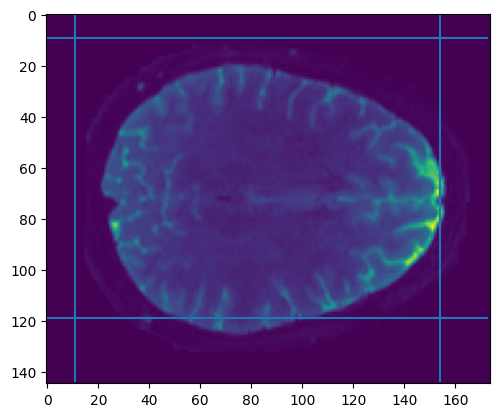

In [93]:
plt.imshow(vol[:,:,80,0])
plt.hlines(curr_blk['lr'][1][0],0,vol.shape[1]-1)
plt.hlines(curr_blk['lr'][0][0],0,vol.shape[1]-1)
plt.vlines(curr_blk['lr'][1][1],0,vol.shape[0]-1)
plt.vlines(curr_blk['lr'][0][1],0,vol.shape[0]-1)

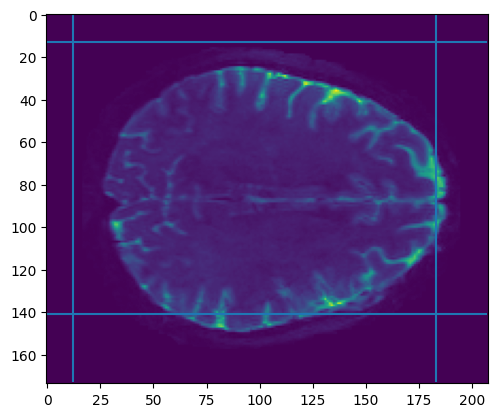

In [91]:
plt.imshow(vol_hr[:,:,80,0])
plt.hlines(curr_blk['hr'][1][0],0,vol_hr.shape[1]-1)
plt.hlines(curr_blk['hr'][0][0],0,vol_hr.shape[1]-1)
plt.vlines(curr_blk['hr'][1][1],0,vol_hr.shape[0]-1)
plt.vlines(curr_blk['hr'][0][1],0,vol_hr.shape[0]-1)

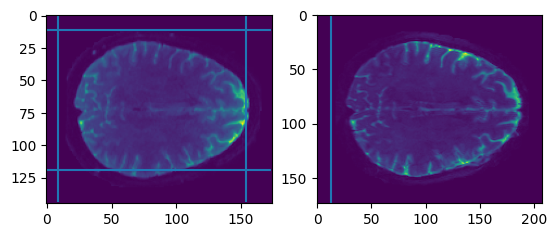

In [68]:
fig, ax = plt.subplots(1,2)
ax[1].imshow(vol_hr[:,:,80,0])
ax[1].vlines(13,0,vol_hr.shape[0]-1)
ax[0].imshow(vol[:,:,80,0])
ax[0].vlines(9,0,vol.shape[0]-1)
ax[0].hlines(11,0,vol.shape[1]-1)
ax[0].vlines(154,0,vol.shape[0]-1)
ax[0].hlines(119,0,vol.shape[1]-1)

In [15]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(16,16,4),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(64,64,16),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(2,1.5,1),
                    help="test_size")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.scale = (1.2,1.2,1)
args.thres = 0.7
print(args)

Namespace(batch_size=4, block_size=(16, 16, 4), crop_depth=15, debug=True, dir='/storage', preload=True, ret_points=True, scale=(1.2, 1.2, 1), sort=True, test_size=(64, 64, 16), thres=0.7)


In [16]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
load_data(args.dir,ids)

[1.2, 1.2, 1.0]


['100610', '102311', '102816', '104416', '105923']

In [17]:
training_dataset = hcp_data(args,ids)

100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded


In [18]:
len(training_dataset)

4797

In [19]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape,x[4].shape,x[5].shape,x[6])

(16, 16, 4, 7) (19, 19, 4) (19, 19, 4) (19, 19, 4, 3) (6,) (6,) 100610


In [20]:
shape_ratio

[1.2, 1.2, 1.0]

In [21]:
def resize(data,ret_pnt = True):
    if(ret_pnt == False):
        x,y = [],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))
    else:
        x,y,z,vols = [],[],[],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
            z.append({'lr':data[i][4],'hr':data[i][5]})
            vols.append(data[i][6])
        lr = torch.from_numpy(np.stack(x))
        pred = torch.from_numpy(np.stack(y))
        return lr,pred,z,vols

In [22]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [23]:
l=8
temp = next(iter(training_data_loader))

In [28]:
len(temp[2])

8

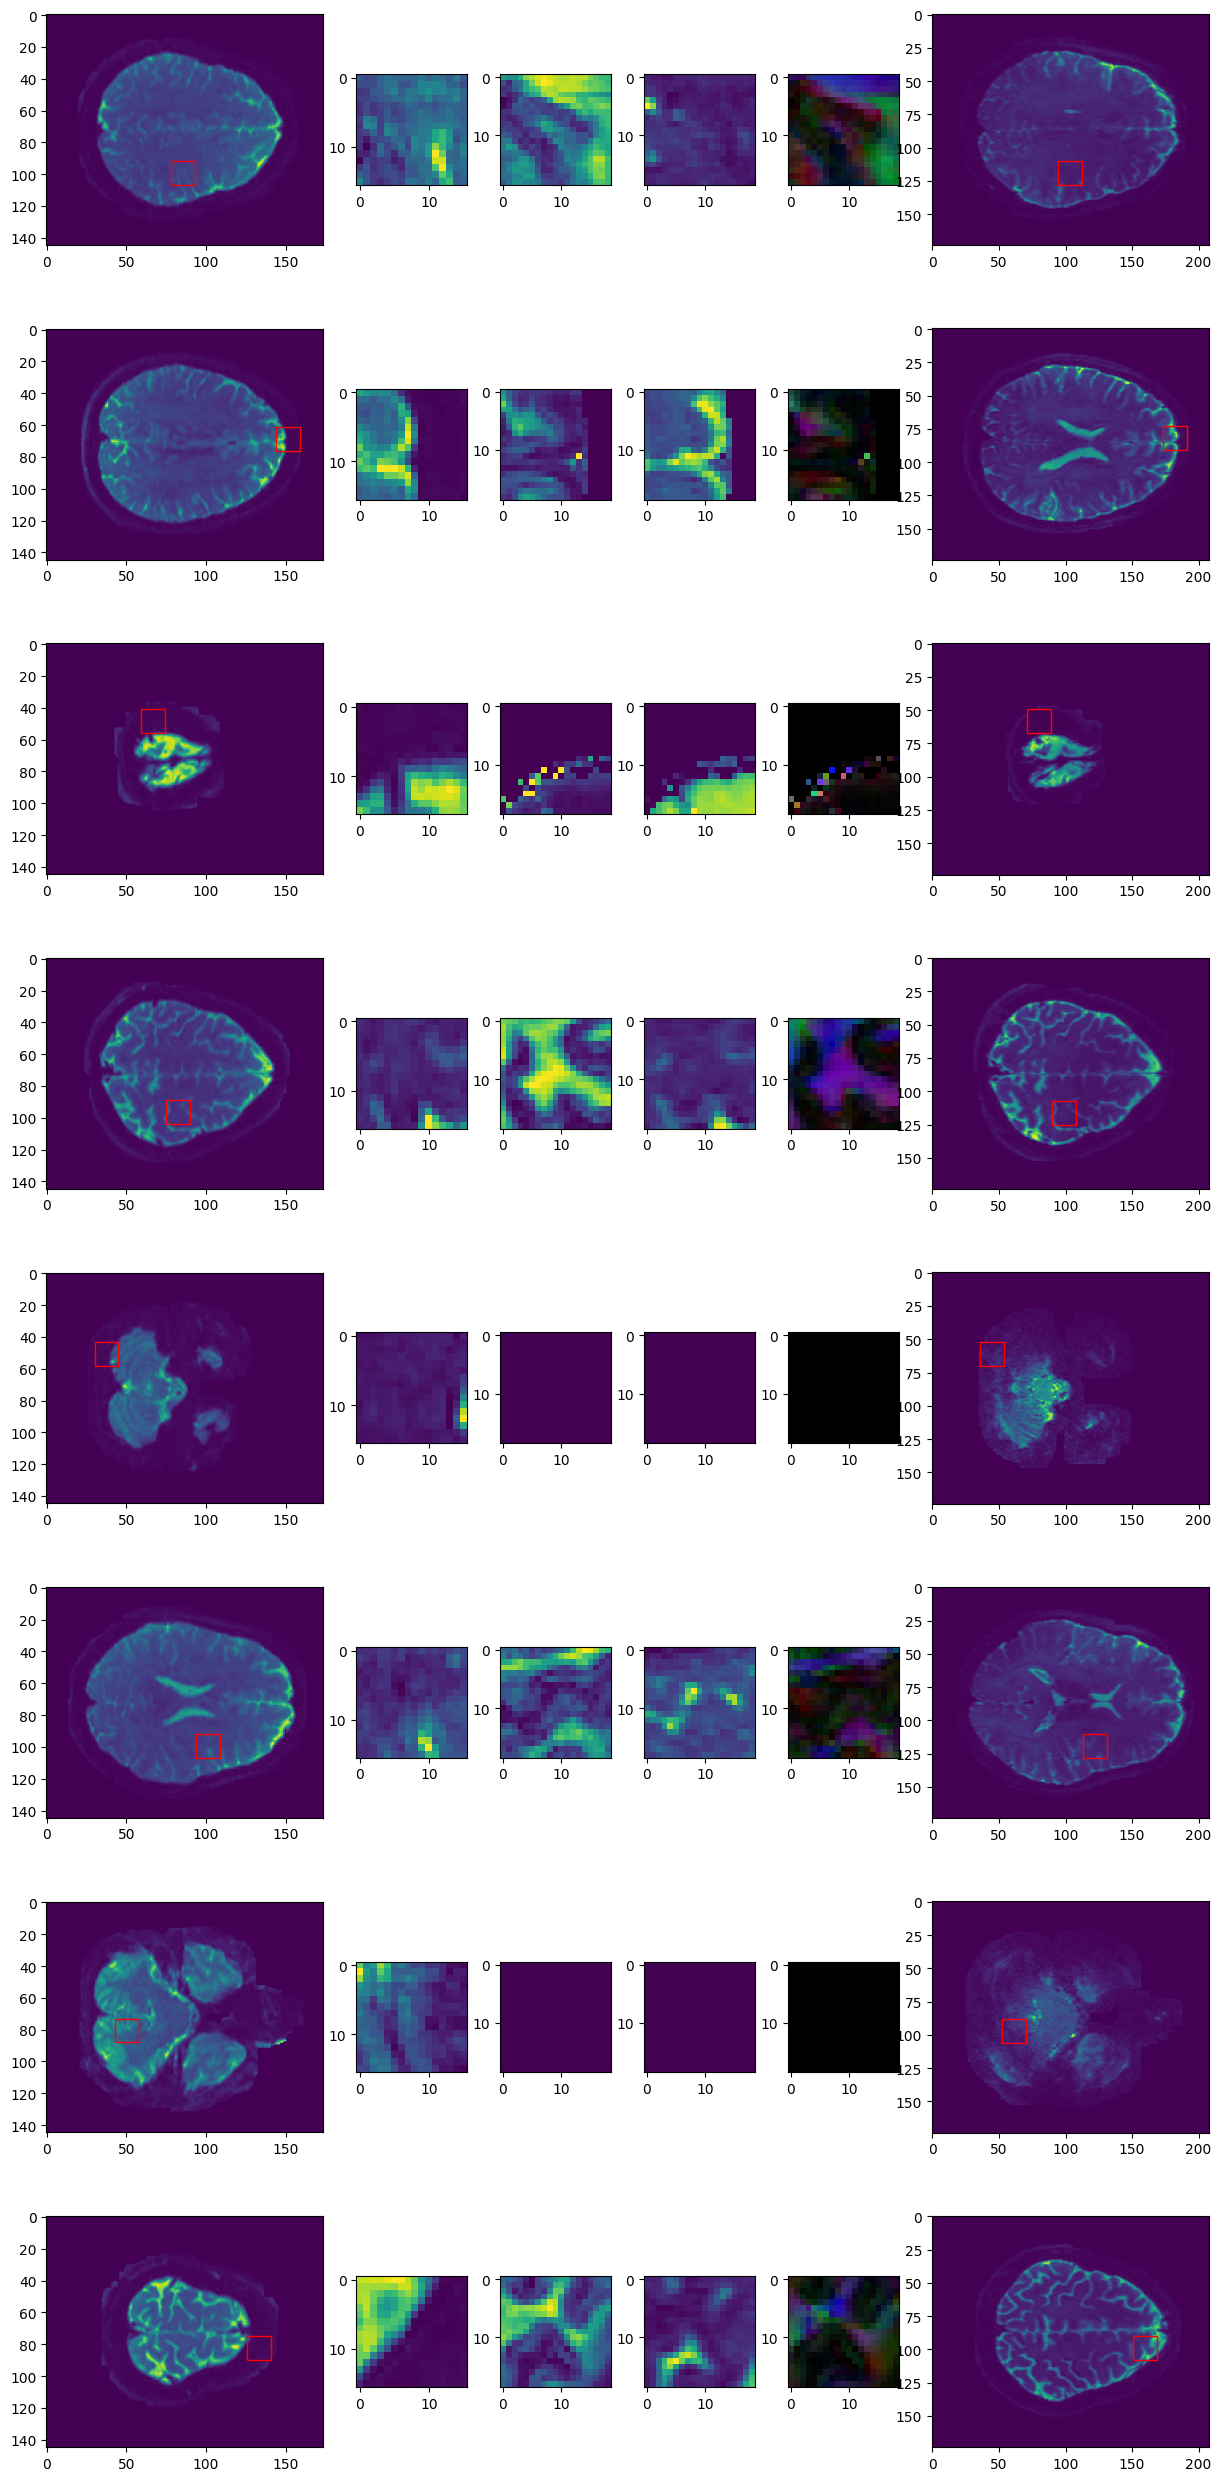

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,6,gridspec_kw={'width_ratios': [2.5, 1,1,1,1,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)

for i in range(l):
    
    data_3t= loaded[temp[3][i]]['vol0']
    size = [int(args.scale[i] * data_3t.shape[i]) for i in range(3)]
    data_7t= interpolate(torch.from_numpy(loaded_gt[temp[3][i]]['vol0']),size = size)
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(temp[0][i,:,:,0,0])
    ax[i][2].imshow(temp[1][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,1])
    ax[i][4].imshow(temp[1][i,:,:,0,2:])
#     ax[i][5].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][5].imshow(data_7t[:,:,sliceee,0])
    ax[i][5].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()

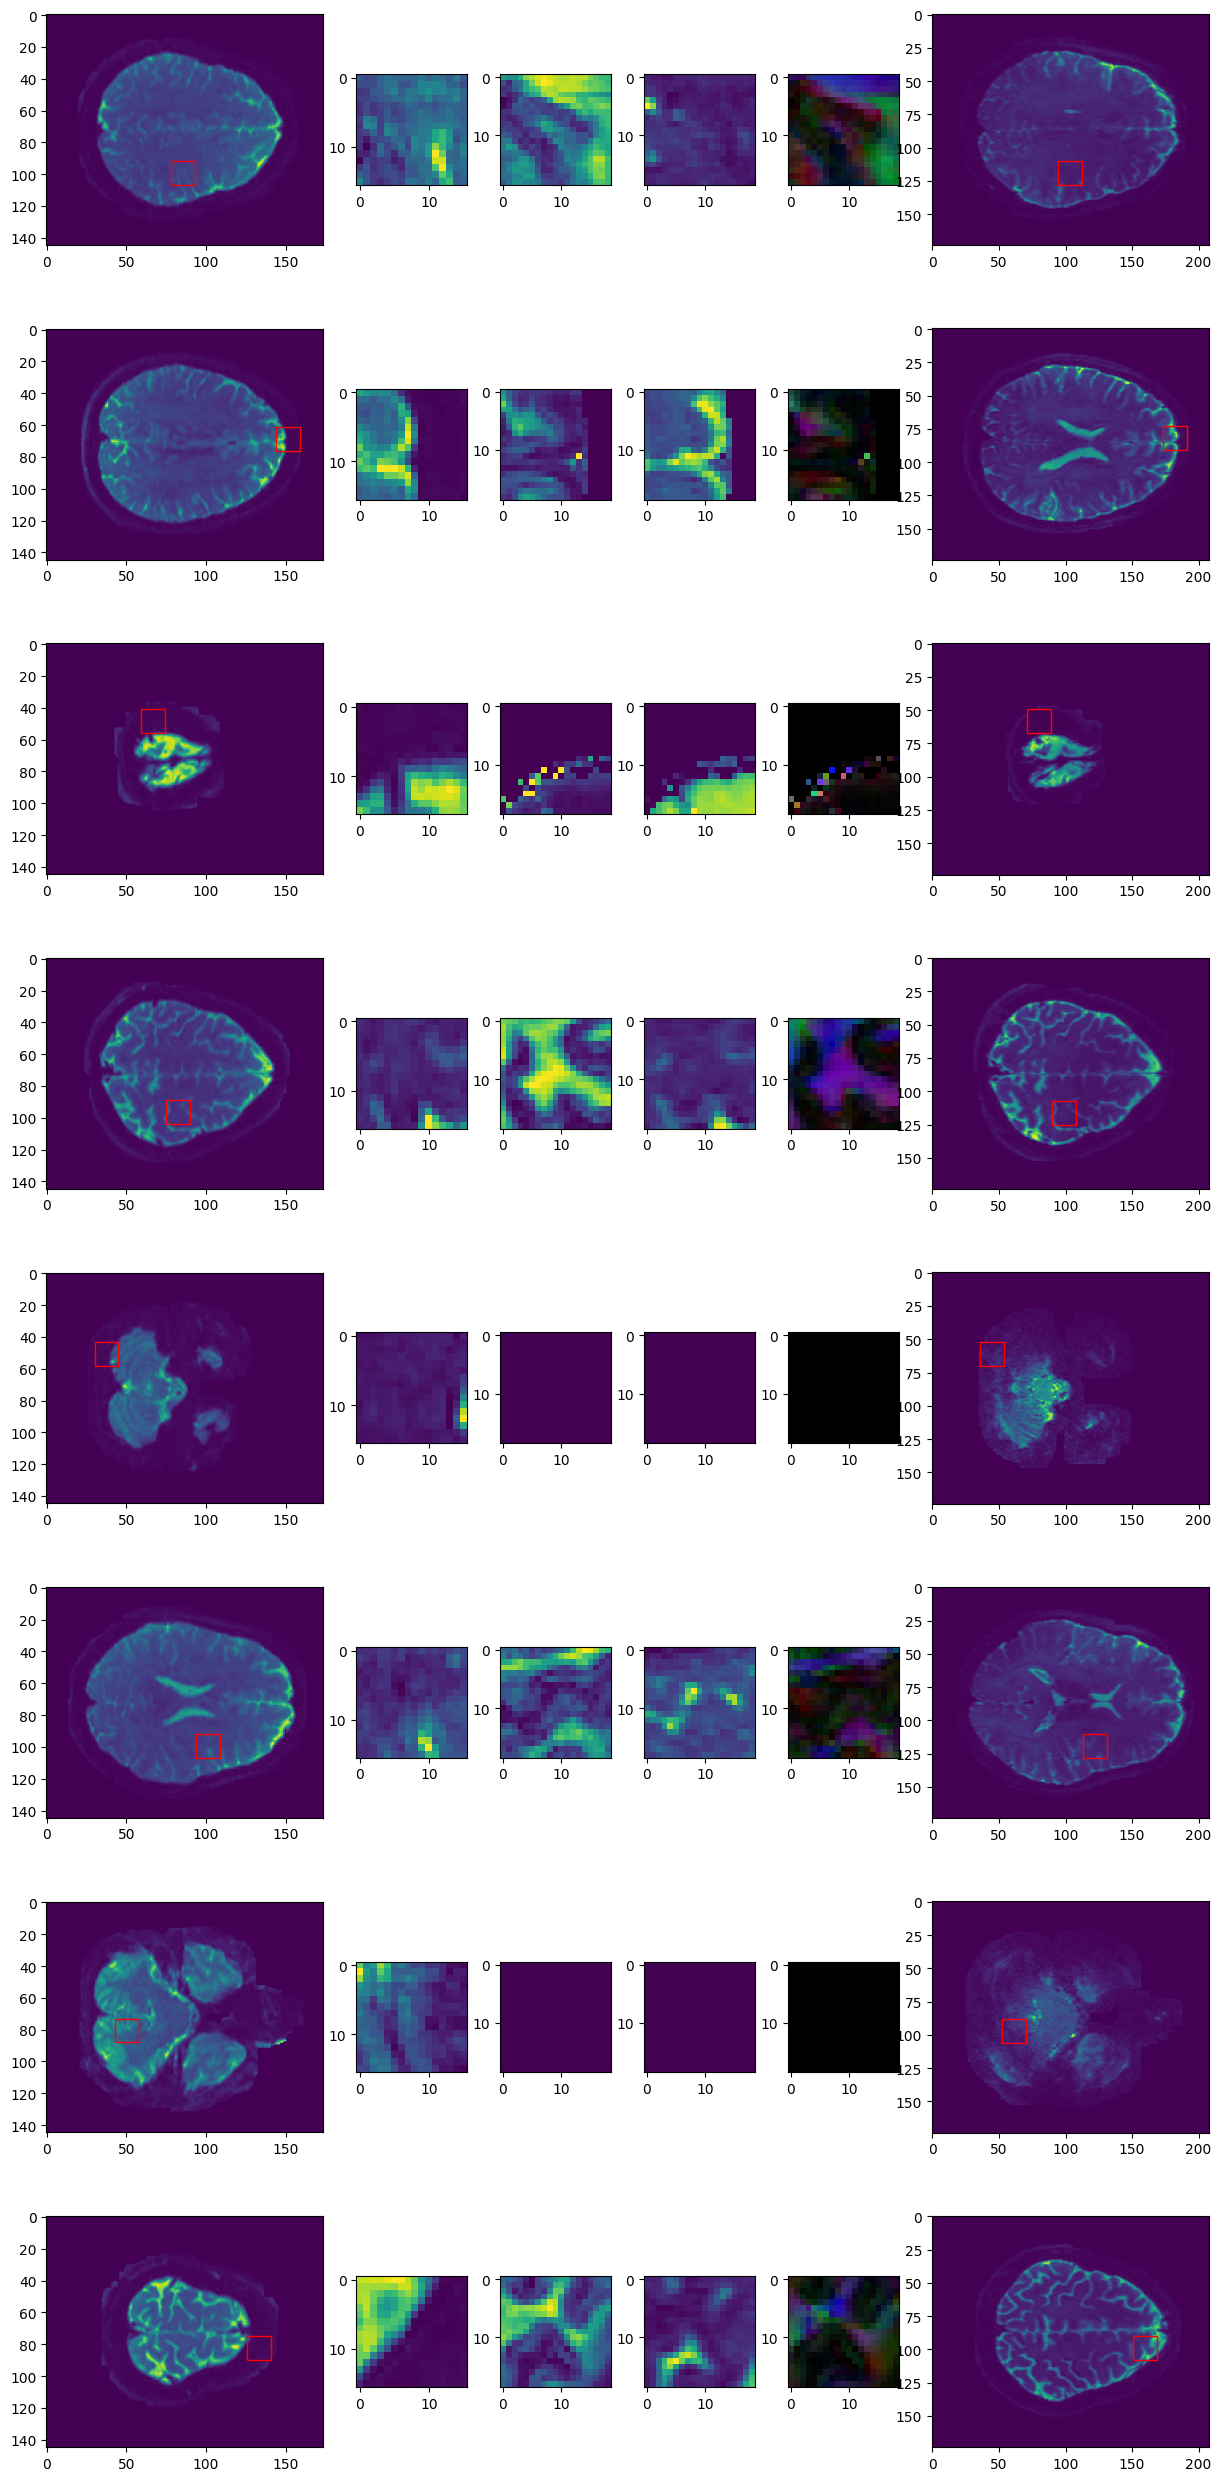

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,6,gridspec_kw={'width_ratios': [2.5, 1,1,1,1,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)

for i in range(l):
    
    data_3t= loaded[temp[3][i]]['vol0']
    size = [int(args.scale[i] * data_3t.shape[i]) for i in range(3)]
    data_7t= interpolate(torch.from_numpy(loaded_gt[temp[3][i]]['vol0']),size = size)
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(temp[0][i,:,:,0,0])
    ax[i][2].imshow(temp[1][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,1])
    ax[i][4].imshow(temp[1][i,:,:,0,2:])
#     ax[i][5].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][5].imshow(data_7t[:,:,sliceee,0])
    ax[i][5].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()